### 1.1 Importar Libs

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
import pickle
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

# Importar XGBoost
try:
    import xgboost as xgb
    print(f"XGBoost: {xgb.__version__}")
except ImportError:
    print("❌ XGBoost não encontrado. Instale com: pip install xgboost")
    raise

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print("Bibliotecas importadas com sucesso!")

XGBoost: 3.1.2
Pandas: 2.3.3
NumPy: 2.3.3
Scikit-learn: 1.7.2
Bibliotecas importadas com sucesso!


### 1.2 Carregar Datasets

In [2]:
# Carregamento e preparação inicial dos dados
print("Carregando datasets...")

# Carregar datasets pré-processados
train_data = pd.read_csv('../dataset_sepsis_prepared.csv')
test_data = pd.read_csv('../dataset_sepsis_test_prepared.csv')

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")

# Separar features e target
X_train = train_data.drop('SepsisLabel', axis=1)
y_train = train_data['SepsisLabel']
X_test = test_data.drop('SepsisLabel', axis=1)
y_test = test_data['SepsisLabel']

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

Carregando datasets...
Dataset de treino: (853006, 19)
Dataset de teste: (215171, 19)
Dataset de treino: (853006, 19)
Dataset de teste: (215171, 19)

Distribuição das classes:
Treino: {0.0: 831112, 1.0: 21894}
Teste: {0.0: 209675, 1.0: 5496}

Distribuição das classes:
Treino: {0.0: 831112, 1.0: 21894}
Teste: {0.0: 209675, 1.0: 5496}


In [3]:
train_data.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,WBC,Platelets,Gender,Unit1,Unit2,HospAdmTime,ICULOS,Critical_Risk_Window,Time_Category,SepsisLabel
0,8,-1.109794,-0.460180,-0.936182,2.873365,3.044201,2.159974,-0.073601,-0.277186,-1.393580,0.450716,1.0,1.0,0.0,-12.06,9.0,0,0,0.0
1,47,0.569971,-2.437770,0.173477,0.393960,0.650783,0.430943,-0.997324,0.309171,0.245616,-0.275108,1.0,1.0,0.0,-0.05,48.0,0,1,0.0
2,6,0.150030,0.978068,0.016114,-0.983487,-0.553850,-0.198683,-0.073601,-0.310739,0.121368,-0.191266,1.0,1.0,0.0,-0.02,7.0,0,0,0.0
3,39,-0.269912,0.258944,0.289355,0.853109,0.405094,-0.115460,0.752015,0.298591,-0.003965,-3.152920,0.0,0.0,1.0,-75.85,43.0,0,1,0.0
4,127,0.569971,-0.460180,0.007012,0.761279,1.834255,1.055050,-0.520987,0.702140,-0.180545,0.030433,0.0,0.0,1.0,-0.03,128.0,1,2,0.0


## 2. Sampling para Busca de Hiperparâmetros

In [4]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Amostra estratificada do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.05, 
    stratify=y_train,
    random_state=10
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 853,006 amostras
Amostra para busca de hiperparâmetros: 42,651 amostras
Redução: 95.0%

Distribuição das classes na amostra:
Amostra: {0.0: 41556, 1.0: 1095}
Original: {0.0: 831112, 1.0: 21894}
Dataset original de treino: 853,006 amostras
Amostra para busca de hiperparâmetros: 42,651 amostras
Redução: 95.0%

Distribuição das classes na amostra:
Amostra: {0.0: 41556, 1.0: 1095}
Original: {0.0: 831112, 1.0: 21894}


## 3. Funções Auxiliares

In [5]:
# Função auxiliar para cálculo do G-Mean
def gmean_score(y_true, y_pred):
    """Calcula o G-Mean (Geometric Mean) para problemas binários"""
    # Sensitivity (recall da classe positiva - sepsis)
    sensitivity = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    # Specificity (recall da classe negativa - sem sepsis)
    specificity = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
    # G-Mean é a média geométrica de sensitivity e specificity
    return np.sqrt(sensitivity * specificity)

# Função para avaliar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Avalia um modelo treinado e retorna métricas completas"""
    # Predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas de treino
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred, zero_division=0),
        'recall': recall_score(y_train, y_train_pred, zero_division=0),
        'f1': f1_score(y_train, y_train_pred, zero_division=0),
        'gmean': gmean_score(y_train, y_train_pred)
    }
    
    # Métricas de teste
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, zero_division=0),
        'recall': recall_score(y_test, y_test_pred, zero_division=0),
        'f1': f1_score(y_test, y_test_pred, zero_division=0),
        'gmean': gmean_score(y_test, y_test_pred)
    }
    
    # AUC-ROC para problemas binários
    try:
        y_test_proba = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
        test_metrics['auc_roc'] = roc_auc_score(y_test, y_test_proba)
        
        # AUC-ROC para treino também
        y_train_proba = model.predict_proba(X_train)[:, 1]
        train_metrics['auc_roc'] = roc_auc_score(y_train, y_train_proba)
    except Exception as e:
        test_metrics['auc_roc'] = None
        train_metrics['auc_roc'] = None
    
    return train_metrics, test_metrics, y_test_pred

# Função para plotar histórico de busca
def plot_search_history(search_results, model_name, metric='mean_test_score'):
    """Plota a evolução dos resultados durante a busca de hiperparâmetros"""
    plt.figure(figsize=(12, 6))
    
    results_df = pd.DataFrame(search_results.cv_results_)
    
    plt.subplot(1, 2, 1)
    plt.plot(results_df[metric], 'b-o', alpha=0.7)
    plt.fill_between(range(len(results_df)), 
                     results_df[metric] - results_df['std_test_score'],
                     results_df[metric] + results_df['std_test_score'], 
                     alpha=0.3)
    plt.title(f'{model_name} - Evolução do F1-Score')
    plt.xlabel('Iteração')
    plt.ylabel('F1-Score (CV)')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    # Verificar se existe coluna de treino
    if 'mean_train_score' in results_df.columns:
        plt.plot(results_df['mean_train_score'], 'g-o', alpha=0.7, label='Treino')
    plt.plot(results_df[metric], 'b-o', alpha=0.7, label='Validação')
    plt.title(f'{model_name} - Treino vs Validação')
    plt.xlabel('Iteração')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Função para executar múltiplas buscas de hiperparâmetros
def multiple_randomized_search(estimator, param_distributions, X, y, cv_strategy, 
                              n_searches=20, n_iter_per_search=80, scoring='f1', 
                              random_state=42, n_jobs=-1, verbose=0):
    """
    Executa múltiplas buscas RandomizedSearchCV e retorna a melhor configuração global
    
    Parameters:
    -----------
    n_searches : int
        Número de execuções do RandomizedSearchCV (default: 20)
    n_iter_per_search : int  
        Número de iterações por execução (default: 80)
    """
    print(f"Executando {n_searches} buscas com {n_iter_per_search} iterações cada...")
    
    best_overall_score = -np.inf
    best_overall_params = None
    best_search_result = None
    all_results = []
    
    for search_idx in range(n_searches):
        print(f"\nBusca {search_idx + 1}/{n_searches}...")
        
        # RandomizedSearchCV para esta execução
        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_distributions,
            n_iter=n_iter_per_search,
            scoring=scoring,
            cv=cv_strategy,
            random_state=None,
            n_jobs=n_jobs,
            return_train_score=True,
            verbose=0  # Menos verbose para múltiplas execuções
        )
        
        search.fit(X, y)
        
        # Armazenar resultados desta busca
        search_results = {
            'search_idx': search_idx,
            'best_score': search.best_score_,
            'best_params': search.best_params_,
            'cv_results': search.cv_results_
        }
        all_results.append(search_results)
        
        # Verificar se esta é a melhor busca até agora
        if search.best_score_ > best_overall_score:
            best_overall_score = search.best_score_
            best_overall_params = search.best_params_
            best_search_result = search
            
        print(f"Melhor score desta busca: {search.best_score_:.4f}")
        print(f"Melhor configuração desta busca: {search.best_params_}")
        print(f"Melhor score geral até agora: {best_overall_score:.4f}")
    
    print(f"\n🎯 Busca completa! Melhor score geral: {best_overall_score:.4f}")
    print(f"Total de configurações testadas: {n_searches * n_iter_per_search:,}")
    
    return best_search_result, all_results, best_overall_params

print("Funções auxiliares definidas com sucesso!")

Funções auxiliares definidas com sucesso!


## 3.1 Definir Folds

In [6]:
# Configuração da validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 4. XGBoost - Busca de Hiperparâmetros

In [7]:
# Definir nome do modelo para uso em salvamento e exibição
MODEL_NAME = "XGBoost"

In [8]:
# ======================================================================
# 4.1 BUSCA DE HIPERPARAMETROS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME}  ===")

# Definição do Espaço de Hiperparâmetros para XGBoost (apenas parâmetros variáveis)
param_distributions = {
    'n_estimators': randint(140, 381),  # Número de árvores
    'max_depth': randint(3, 11),  # Profundidade máxima das árvores
    'learning_rate': uniform(0.5, 1.5),  # Taxa de aprendizado
    'subsample': uniform(0.6, 0.3),  # Fração das amostras para cada árvore
    'colsample_bytree': uniform(0.2, 0.5),  # Fração das features para cada árvore
    'reg_alpha': uniform(0.5, 1.5),  # Regularização L1
    'reg_lambda': uniform(0.5, 1.5),  # Regularização L2
    'min_child_weight': randint(1, 20),  # Peso mínimo das folhas 
    'gamma': uniform(0.1, 0.4),  # Redução mínima de perda para split 
}

# Múltiplas execuções do RandomizedSearchCV
print(f"Iniciando busca de hiperparâmetros para {MODEL_NAME}...")
model_search, model_all_searches, best_params = multiple_randomized_search(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',     # Para classificação binária
        eval_metric='logloss',           # Métrica de avaliação
        random_state=42,                 # Reprodutibilidade
        n_jobs=-1,                       # Usar todos os cores
        verbosity=0                      # Silencioso
    ),
    param_distributions=param_distributions,
    X=X_sample,                  
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,                
    n_iter_per_search=40,      
    scoring='f1',
    n_jobs=-1,
)

# Seleção da Melhor Configuração
print(f"\n--- RESULTADOS {MODEL_NAME} ---")
print("Melhores hiperparâmetros:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {model_search.best_score_:.4f}")

=== BUSCA DE HIPERPARÂMETROS - XGBoost  ===
Iniciando busca de hiperparâmetros para XGBoost...
Executando 20 buscas com 40 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.1138
Melhor configuração desta busca: {'colsample_bytree': np.float64(0.49670959582083624), 'gamma': np.float64(0.2930766375352626), 'learning_rate': np.float64(1.0964680470168306), 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 377, 'reg_alpha': np.float64(1.5552741255793168), 'reg_lambda': np.float64(1.8920483559724621), 'subsample': np.float64(0.8685293636046645)}
Melhor score geral até agora: 0.1138

Busca 2/20...
Melhor score desta busca: 0.1138
Melhor configuração desta busca: {'colsample_bytree': np.float64(0.49670959582083624), 'gamma': np.float64(0.2930766375352626), 'learning_rate': np.float64(1.0964680470168306), 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 377, 'reg_alpha': np.float64(1.5552741255793168), 'reg_lambda': np.float64(1.8920483559724621), 'subsample': np.float64

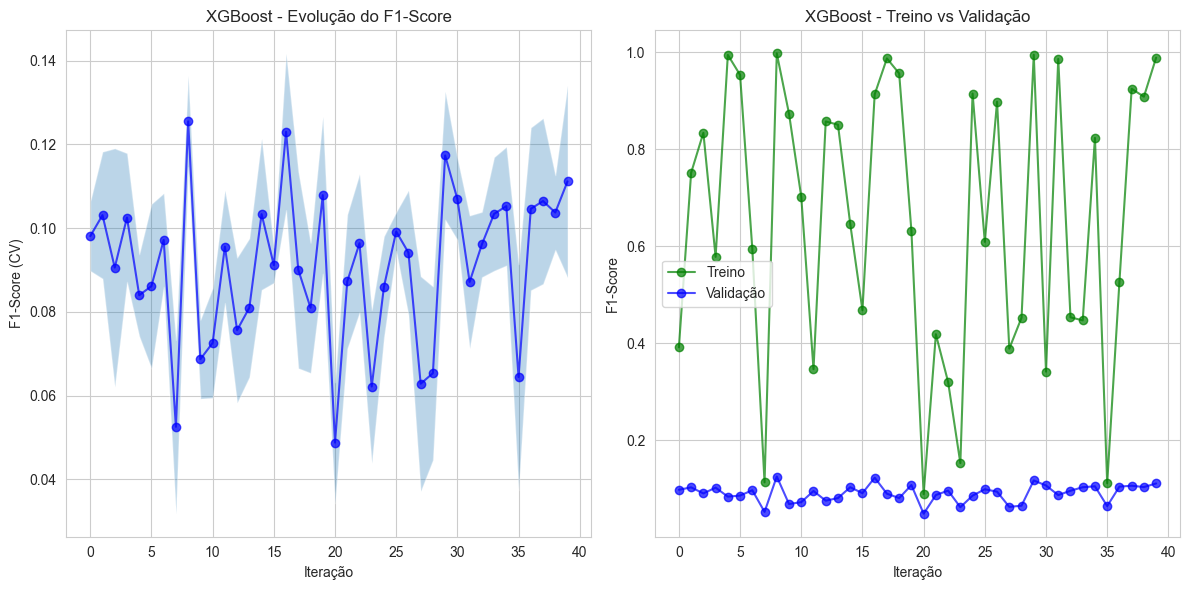

In [9]:
# Registro de Desempenho - plotar evolução
plot_search_history(model_search, MODEL_NAME)

In [10]:
# ======================================================================
# 4.5 ANÁLISE DAS MELHORES CONFIGURAÇÕES ENCONTRADAS
# ======================================================================

print(f"=== TOP 20 MELHORES CONFIGURAÇÕES - {MODEL_NAME} ===")

# Extrair os melhores resultados de cada busca
best_configs = []

for i, search_result in enumerate(model_all_searches):
    config = {
        'Busca': i + 1,
        'F1_Score': search_result['best_score'],
        'N_Estimators': search_result['best_params']['n_estimators'],
        'Max_Depth': search_result['best_params']['max_depth'],
        'Learning_Rate': search_result['best_params']['learning_rate'],
        'Subsample': search_result['best_params']['subsample'],
        'Colsample_Bytree': search_result['best_params']['colsample_bytree'],
        'Reg_Alpha': search_result['best_params']['reg_alpha'],
        'Reg_Lambda': search_result['best_params']['reg_lambda'],
        'Min_Child_Weight': search_result['best_params']['min_child_weight'],
        'Gamma': search_result['best_params']['gamma']
    }
    best_configs.append(config)

# Converter para DataFrame e ordenar por F1-Score
results_df = pd.DataFrame(best_configs)
results_df = results_df.sort_values('F1_Score', ascending=False).reset_index(drop=True)
results_df['Ranking'] = range(1, len(results_df) + 1)

# Reordenar colunas
results_df = results_df[['Ranking', 'Busca', 'F1_Score', 'N_Estimators', 'Max_Depth', 
                        'Learning_Rate', 'Subsample', 'Colsample_Bytree', 'Reg_Alpha', 
                        'Reg_Lambda', 'Min_Child_Weight', 'Gamma']]

# Mostrar tabela formatada
print("Top 20 Configurações (ordenadas por F1-Score Binário):")
print("-" * 170)
print(results_df.to_string(index=False, float_format='%.4f'))

# Estatísticas resumidas
print(f"\n--- ESTATÍSTICAS DAS CONFIGURAÇÕES ---")
print(f"Melhor F1-Score: {results_df['F1_Score'].max():.4f}")
print(f"F1-Score médio: {results_df['F1_Score'].mean():.4f}")
print(f"Desvio padrão: {results_df['F1_Score'].std():.4f}")
print(f"F1-Score mínimo: {results_df['F1_Score'].min():.4f}")

=== TOP 20 MELHORES CONFIGURAÇÕES - XGBoost ===
Top 20 Configurações (ordenadas por F1-Score Binário):
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Ranking  Busca  F1_Score  N_Estimators  Max_Depth  Learning_Rate  Subsample  Colsample_Bytree  Reg_Alpha  Reg_Lambda  Min_Child_Weight  Gamma
       1     11    0.1255           305          9         1.4218     0.6527            0.6502     0.7781      1.5187                 1 0.1370
       2     20    0.1241           285         10         1.2526     0.7973            0.5048     0.7858      0.7104                 2 0.3351
       3     13    0.1241           323          5         1.1177     0.7594            0.2342     1.0859      1.2243                 2 0.4582
       4     17    0.1241           377          5         1.8943     0.8409            0.6245     0.7714      1.9389                 2 0.4297
       5   

## 5. Salvar Resultados de Busca

In [11]:
# Salvar Resultados da Busca de Hiperparâmetros

print(f"=== SALVANDO RESULTADOS DA BUSCA - {MODEL_NAME} ===")

# Criar pasta se não existir
os.makedirs('searches', exist_ok=True)

# 1. Salvar resultados detalhados de todas as buscas
search_detailed_results = []

for i, search_result in enumerate(model_all_searches):
    # Extrair informações de cada busca individual
    cv_results = search_result['cv_results']
    
    for j in range(len(cv_results['mean_test_score'])):
        search_detailed_results.append({
            'search_idx': search_result['search_idx'],
            'iteration': j,
            'mean_test_score': cv_results['mean_test_score'][j],
            'std_test_score': cv_results['std_test_score'][j],
            'mean_train_score': cv_results['mean_train_score'][j] if 'mean_train_score' in cv_results else None,
            'std_train_score': cv_results['std_train_score'][j] if 'std_train_score' in cv_results else None,
            'params': str(cv_results['params'][j]),
            **{k: v for k, v in cv_results['params'][j].items() if k not in ['objective', 'eval_metric', 'random_state', 'n_jobs', 'verbosity']}
        })

# Converter para DataFrame e salvar
search_df = pd.DataFrame(search_detailed_results)
search_df.to_csv(f'searches/{MODEL_NAME.lower()}_all_searches.csv', index=False)

print(f"  Todos os Resultados salvos: searches/{MODEL_NAME.lower()}_all_searches.csv")
print(f"  Total de configurações testadas: {len(search_df):,}")

# 2. Salvar resumo da melhor busca
best_search_summary = {
    'model_name': MODEL_NAME,
    'best_overall_score': model_search.best_score_,
    'best_overall_params': best_params,
    'search_config': {
        'n_searches': 20,
        'n_iter_per_search': 15,
        'scoring': 'f1',
        'cv_folds': 5,
        'total_configurations': len(search_df)
    },
    'top_10_configs': search_df.nlargest(10, 'mean_test_score')[
        ['mean_test_score', 'std_test_score', 'n_estimators', 'max_depth', 
         'learning_rate', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda']
    ].to_dict('records')
}

# Salvar resumo em JSON
with open(f'searches/{MODEL_NAME.lower()}_search_summary.json', 'w') as f:
    json.dump(best_search_summary, f, indent=2)

print(f"  Resumo salvo: searches/{MODEL_NAME.lower()}_search_summary.json")

# Mostrar estatísticas da busca
print(f"\n--- ESTATÍSTICAS DA BUSCA {MODEL_NAME} ---")
print(f"Melhor F1-Score: {model_search.best_score_:.4f}")
print(f"Desvio padrão do melhor: {search_df.loc[search_df['mean_test_score'].idxmax(), 'std_test_score']:.4f}")
print(f"F1-Score médio geral: {search_df['mean_test_score'].mean():.4f}")
print(f"F1-Score mínimo: {search_df['mean_test_score'].min():.4f}")
print(f"F1-Score máximo: {search_df['mean_test_score'].max():.4f}")

=== SALVANDO RESULTADOS DA BUSCA - XGBoost ===
  Todos os Resultados salvos: searches/xgboost_all_searches.csv
  Total de configurações testadas: 800
  Resumo salvo: searches/xgboost_search_summary.json

--- ESTATÍSTICAS DA BUSCA XGBoost ---
Melhor F1-Score: 0.1255
Desvio padrão do melhor: 0.0109
F1-Score médio geral: 0.0898
F1-Score mínimo: 0.0117
F1-Score máximo: 0.1255


## 6. Treinar Modelo Final e Salvar

In [12]:
# Treinamento Final com melhores hiperparâmetros
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

print(f"\nModelo final {MODEL_NAME} treinado: {best_model}")

# Criar pasta se não existir
os.makedirs('models', exist_ok=True)

# Salvar modelo treinado
dump(best_model, f'models/{MODEL_NAME.lower()}_trained.joblib')
print(f"Modelo salvo: models/{MODEL_NAME.lower()}_trained.joblib")


Modelo final XGBoost treinado: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.6502374440504688), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=np.float64(0.13697900853304845), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(1.421780594032561), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=305, n_jobs=None,
              num_parallel_tree=None, ...)
Modelo salvo: models/xgboost_trained.joblib


## 7. Avaliação Final e Salvamento dos Resultados

In [13]:
print(f"=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - {MODEL_NAME} ===")

# Criar pastas se não existirem
os.makedirs('results', exist_ok=True)

# Avaliação completa do modelo
print("\nAvaliando performance do modelo...")

X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# Avaliar modelo
train_metrics, test_metrics, y_pred = evaluate_model(
    best_model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)

# Compilar todos os resultados
model_final_results = {
    'model_name': MODEL_NAME,
    'best_params': best_params,
    'best_cv_score': model_search.best_score_,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'predictions': y_pred.tolist(),
    'test_labels': y_test_eval.tolist(),
    'evaluation_info': {
        'train_samples_used': len(X_train_eval),
        'test_samples_used': len(X_test_eval),
        'total_train_samples': len(X_train_scaled),
        'total_test_samples': len(X_test_scaled)
    }
}

# Salvar resultados em JSON
with open(f'results/{MODEL_NAME.lower()}_results.json', 'w') as f:
    json.dump(model_final_results, f, indent=2)

print(f"Resultados {MODEL_NAME} salvos em: results/{MODEL_NAME.lower()}_results.json")

# Mostrar resumo
print(f"\n--- RESUMO {MODEL_NAME} ---")
print(f"F1-Score CV: {model_final_results['best_cv_score']:.4f}")
print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
print(f"Acurácia Teste: {test_metrics['accuracy']:.4f}")
print(f"Precisão Teste: {test_metrics['precision']:.4f}")
print(f"Recall Teste: {test_metrics['recall']:.4f}")
print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
if test_metrics['auc_roc']:
    print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")

=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - XGBoost ===

Avaliando performance do modelo...
Resultados XGBoost salvos em: results/xgboost_results.json

--- RESUMO XGBoost ---
F1-Score CV: 0.1255
F1-Score Teste: 0.1399
Acurácia Teste: 0.9528
Precisão Teste: 0.1308
Recall Teste: 0.1503
G-Mean Teste: 0.3826
AUC-ROC Teste: 0.5233
Resultados XGBoost salvos em: results/xgboost_results.json

--- RESUMO XGBoost ---
F1-Score CV: 0.1255
F1-Score Teste: 0.1399
Acurácia Teste: 0.9528
Precisão Teste: 0.1308
Recall Teste: 0.1503
G-Mean Teste: 0.3826
AUC-ROC Teste: 0.5233
